In [1]:
%load_ext autoreload
%autoreload 2

import torch

from lib.model.single_layer.SingleLayer import SingleLayer
from lib.model.single_layer.TwoLayer import TwoLayer
from lib.model.single_layer.init_model import init_model
from fitness_predictor import train_predictor
from lib.data.data import resample_uniform
from lib.utils.metric import get_outputs, pair_ranking_accuracy, treshold_discrimination

s:\Documents\master\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Trained model sandbox

In [2]:
model = init_model(
    #model = SingleLayer,
    model = TwoLayer,

    activation_function=torch.nn.Sigmoid(),
    #activation_function=torch.nn.LeakyReLU(),
    #activation_function=torch.nn.Identity(),

    embedding_size=1280, # ESM-1b
    #embedding_size=1024, # Progen2
    
    state_dict_path="/models/two_layer_esm-1b/two_layer_esm-1b_sigmoid_03.pt",
    #state_dict_path="/models/two_layer_esm-1b/two_layer_esm-1b_identity_01.pt",
    #state_dict_path="/models/single_layer_esm-1b/single_layer_esm-1b_sigmoid_01.pt",
    #state_dict_path="/models/single_layer_esm-1b/single_layer_esm-1b_identity_01.pt",
    #state_dict_path="/models/two_layer_progen2/two_layer_progen2_sigmoid_02.pt",
    #state_dict_path="/models/single_layer/single_layer_sigmoid_04.pt",
    #state_dict_path="/models/single_layer/single_layer_leakyRELU_01.pt",
    #state_dict_path="/models/single_layer/single_layer_identity_02.pt",
    #state_dict_path=None,

    absolute_path=False,
)

loading model state dict from file "s:\Documents\master\code\llm/models/two_layer_esm-1b/two_layer_esm-1b_sigmoid_03.pt"


In [77]:
info = torch.load("./models/two_layer_esm-1b/two_layer_esm-1b_sigmoid_04_info.pt")
info

{'loss_function': <function torch.nn.functional.l1_loss(input: torch.Tensor, target: torch.Tensor, size_average: Optional[bool] = None, reduce: Optional[bool] = None, reduction: str = 'mean') -> torch.Tensor>,
 'learning_rate': 0.0001,
 'batch_size': 100,
 'n_epochs': 1,
 'evaluation_period': 1,
 'test_split': None,
 'train_variants': array(['LWAA', 'WWCA', 'WWFV', 'VWAA', 'WWLC', 'YYAA', 'FWCA', 'WWLT',
        'FWLG', 'VAAA', 'WYCA', 'AWCA', 'FWAG', 'FYAA', 'FFAA', 'IWCA',
        'FYAG', 'FWAA', 'ANCA', 'WWLG', 'LWCA', 'WWMA', 'AYCA', 'IWAA',
        'WWLA', 'WWFG', 'LWLG'], dtype=object),
 'test_variants': array(['LWAA', 'WWCA', 'WWFV', 'VWAA', 'WWLC', 'YYAA', 'FWCA', 'WWLT',
        'FWLG', 'VAAA', 'WYCA', 'AWCA', 'FWAG', 'FYAA', 'FFAA', 'IWCA',
        'FYAG', 'FWAA', 'ANCA', 'WWLG', 'LWCA', 'WWMA', 'AYCA', 'IWAA',
        'WWLA', 'WWFG', 'LWLG'], dtype=object),
 'train_time': 11.208126068115234,
 'loss_history': tensor([[0.2411],
         [0.1733]])}

In [22]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0064,  0.0080, -0.0165,  ..., -0.0146,  0.0155,  0.0180],
         [-0.0140,  0.0186,  0.0024,  ...,  0.0262,  0.0287,  0.0236],
         [ 0.0057, -0.0309,  0.0126,  ...,  0.0176, -0.0240,  0.0156],
         ...,
         [ 0.0226,  0.0257,  0.0011,  ..., -0.0149, -0.0101,  0.0036],
         [-0.0199,  0.0266, -0.0190,  ..., -0.0064, -0.0103,  0.0212],
         [-0.0043,  0.0095,  0.0063,  ...,  0.0228, -0.0080,  0.0223]],
        requires_grad=True),
 Parameter containing:
 tensor([[-0.0049, -0.0210,  0.0143,  ..., -0.0129, -0.0263, -0.0169]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0075], requires_grad=True)]

In [3]:
embedding = torch.load("./../../data/GB1/progen2_embedding.pt")

In [21]:
embedding = torch.load("./../../data/GB1/esm-1b_embedding.pt")

In [4]:
df = torch.load("./../../data/GB1/progen2_dataframe.pt")

In [2]:
df = torch.load("./../../data/GB1/esm-1b_dataframe.pt")

In [6]:
dfa = df.loc[df["Fitness"] >= 1.0]
embedding = torch.stack(tuple(dfa["Embedding"].values))
fitness_norm = dfa["Fitness_norm"].values
print(len(fitness_norm))
outputs = get_outputs(model, embedding).detach().numpy()

dfa["Prediction"] = outputs
dfa = dfa.sort_values("Prediction", ascending=False)

3644


C:\Users\Matouš\AppData\Local\Temp\ipykernel_13756\2222219320.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfa["Prediction"] = outputs


In [7]:
top_k = dfa[0:10]
#top_k["Fitness_norm"].sort_values(ascending=False).values
top_k["Fitness_norm"].values.mean()

0.39722756654916014

In [162]:
pair_ranking_accuracy(outputs, fitness_norm)

0.53360768175583

In [179]:
# 1.0 -> 0.1141296416002635 (normalized)
treshold_discrimination(outputs, fitness_norm, 0.12)

0.9621295279912184

In [8]:
dff = df.loc[df["Fitness"] >= 1.0]
embedding = torch.stack(tuple(dff["Embedding"].values))
fitness = dff["Fitness"].values
embedding.size()


torch.Size([3644, 1280])

In [9]:
predictions = torch.empty(len(embedding))
for emb in range(len(embedding)):
    predictions[emb] = model(embedding[emb])
pred = predictions.clone().detach().numpy()

Text(0.5, 1.0, 'Fitness distribution')

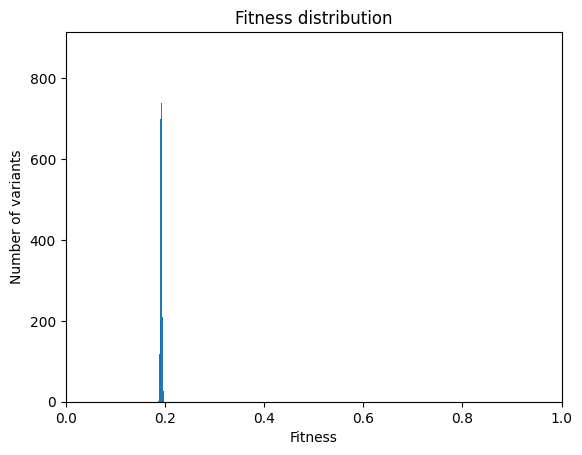

In [10]:
import matplotlib.pyplot as plt

n_bins = 1000
plt.hist(
    pred,
    n_bins,
    range=(0.0, 1.0),
)
plt.xlim([0, 1])
plt.xlabel("Fitness")
plt.ylabel("Number of variants")
plt.title("Fitness distribution")

In [8]:
#fitness_norm = torch.load("./../../data/GB1/progen2_fitness_norm.pt")
df = torch.load("./../../data/GB1/progen2_dataframe.pt")

In [157]:
df.loc[df["Fitness"] == 1.0]["Fitness_norm"].values[0]

0.1141296416002635

In [9]:
from lib.data.data import resample_uniform

fvals = resample_uniform(df, bins=[1.0, max(df["Fitness"])])
fvals = fvals.Fitness_norm.values
fvals.size

3644

In [10]:
fvals.mean()

0.2549202310863438

Text(0.5, 1.0, 'Fitness distribution')

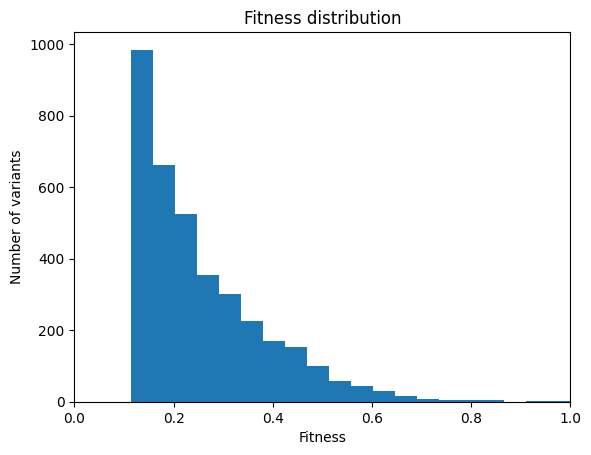

In [11]:
import matplotlib.pyplot as plt

n_bins = 20
plt.hist(
    fvals,
    n_bins,
)
plt.xlim([0, 1])
plt.xlabel("Fitness")
plt.ylabel("Number of variants")
plt.title("Fitness distribution")

In [9]:
dff = df.loc[df["Fitness_norm"] >= 0.9]
dff
#out = model(dff.Embedding.values[0])
#out

,Variants,Fitness,Fitness_norm,Sequences,Embedding
36579,FYAA,8.045152,0.91819,"[tensor(16), tensor(20), tensor(28), tensor(14...","[tensor(3.9249), tensor(-6.1882), tensor(4.781..."
99291,FWAA,8.761966,1.00000,"[tensor(16), tensor(20), tensor(28), tensor(14...","[tensor(3.9575), tensor(-6.2317), tensor(4.770..."


In [10]:
dff = resample_uniform(df, bins=[1.0, max(df["Fitness"])])
prediction = torch.empty(len(dff))
tf = torch.empty(len(dff))
i = 0
for index, row in dff.iterrows():
    prediction[i] = model(row['Embedding'])
    tf[i] = row['Fitness_norm']
    i = i + 1

prediction = prediction.clone().detach().numpy()
#tf = tf.clone().detach().numpy()
#prediction = [p for p in prediction]
#tf = [f for f in tf]

Text(0, 0.5, 'Predicted fitness')

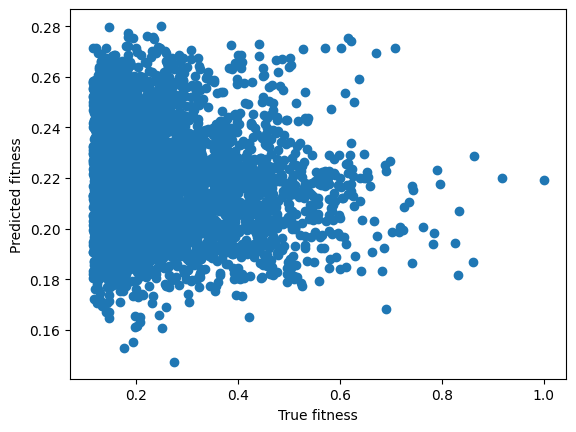

In [11]:
import matplotlib.pyplot as plt

plt.scatter(tf, prediction)
#plt.xlim([0, 1])
plt.xlabel("True fitness")
plt.ylabel("Predicted fitness")

In [15]:
from lib.functional.wieghted_l1_loss import weighted_l1_Loss

i = torch.ones(100) * 2.
t = torch.ones(100) * 3.

loss = weighted_l1_Loss()
loss(input=i, target=t).size()


torch.Size([100])

Save as .csv file

In [4]:
import pandas

In [66]:
pandas.DataFrame(embedding).to_csv("../../data/GB1/GB1_ESM-1b.csv", index=False)

Test

In [3]:
df

,Variants,Fitness,Fitness_norm,Sequences,Embedding
0,PMHE,0.000000,0.000000,"[tensor(0), tensor(20), tensor(16), tensor(19)...","[tensor(-0.0160), tensor(0.1180), tensor(-0.06..."
1,CSCP,0.009092,0.001038,"[tensor(0), tensor(20), tensor(16), tensor(19)...","[tensor(-0.0208), tensor(0.1096), tensor(-0.02..."
2,HEGK,0.005014,0.000572,"[tensor(0), tensor(20), tensor(16), tensor(19)...","[tensor(-0.0167), tensor(0.1268), tensor(-0.03..."
3,RFIL,0.003018,0.000344,"[tensor(0), tensor(20), tensor(16), tensor(19)...","[tensor(-0.0248), tensor(0.1246), tensor(-0.02..."
4,TQTN,0.000000,0.000000,"[tensor(0), tensor(20), tensor(16), tensor(19)...","[tensor(0.0249), tensor(0.1418), tensor(-0.020..."
...,...,...,...,...,...
149356,SGFE,0.002655,0.000303,"[tensor(0), tensor(20), tensor(16), tensor(19)...","[tensor(-0.0233), tensor(0.1174), tensor(-0.04..."
149357,IRIF,0.001638,0.000187,"[tensor(0), tensor(20), tensor(16), tensor(19)...","[tensor(-0.0372), tensor(0.1294), tensor(-0.00..."
149358,GHFP,0.024405,0.002785,"[tensor(0), tensor(20), tensor(16), tensor(19)...","[tensor(-0.0376), tensor(0.1305), tensor(-0.04..."
149359,LTNC,0.012200,0.001392,"[tensor(0), tensor(20), tensor(16), tensor(19)...","[tensor(-0.0221), tensor(0.1299), tensor(-0.01..."
